Image Generation With GAN Model  

Carrissa Gloria Herman  

In [1]:
# tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.metrics import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os
import PIL
import time
from IPython import display

# EDA

In [2]:
filepath = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'

In [3]:
# cek jumlah foto - untuk lihat kira-kira seberapa besar scale dari dataset yang akan digunakan dan berapa banyak informasi yang dipelajari model
for dirpath, dirnames, filenames in os.walk(filepath):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# cek aspect ratio dari tiap gambar
all_filepath = os.listdir(filepath)
import math
import cv2

count = 1

for i in all_filepath:
    # print(i)
    filedir = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'
    image_path = os.path.join(filedir, i)
    # print(image_path)
    image = cv2.imread(image_path)
    # print(type(image))
    x_ratio = int(image.shape[1]/math.gcd(image.shape[1], image.shape[0]))
    y_ratio = int(image.shape[0]/math.gcd(image.shape[1], image.shape[0]))
    # print(count)
    curr_x_ratio = x_ratio
    curr_y_ratio = y_ratio


    if(count == 1):
      print("Aspect ratio of images")
      print("{}. {}:{}".format(count, curr_x_ratio, curr_y_ratio))
      count += 1
      # print(count)

    elif(curr_x_ratio!=x_ratio or curr_y_ratio!=y_ratio):
      count+=1
      print("{}. {}:{}".format(count, curr_x_ratio, curr_y_ratio))


if(count == 2):
  print("All images have an aspect ratio of: {}:{}".format(curr_x_ratio, curr_y_ratio))


Aspect ratio of images
1. 1:1
All images have an aspect ratio of: 1:1


In [8]:
# cek size tiap gambar - untuk cek apakah gambar perlu di-resize
count = 1

for i in all_filepath:
    # print(i)
    filedir = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'
    image_path = os.path.join(filedir, i)
    # print(image_path)
    image = cv2.imread(image_path)
    # print(type(image))
    x = int(image.shape[1])
    y = int(image.shape[0])
    # print(count)
    curr_x = x
    curr_y = y


    if(count == 1):
      print("Images' size:")
      print("{}. {}:{}".format(count, curr_x, curr_y))
      count += 1
      # print(count)

    elif(curr_x!=x or curr_y!=y):
      count+=1
      print("{}. {}:{}".format(count, curr_x, curr_y))


if(count == 2):
  print("All images have an size of: {}:{}".format(curr_x, curr_y))


Images' size:
1. 600:600
All images have an size of: 600:600


In [9]:
from PIL import Image

In [10]:
# cek apakah gambar greyscale atau tidak
image_modes = {}
for i in all_filepath:
    # print(i)
    filedir = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'
    image_path = os.path.join(filedir, i)
    # print(image_path)
    image = cv2.imread(image_path)
    # print(image)
    image2 = Image.open(image_path)
    # print(type(image2))
    # print(image2)
    image_modes[image2.mode] = image_modes.get(image2.mode, 0) + 1

if len(image_modes) == 1:
    print(f"All images have the same mode/channels: {list(image_modes.keys())[0]}")
else:
    print("Image modes are mixed. Channel conversion will be needed.")

All images have the same mode/channels: RGB


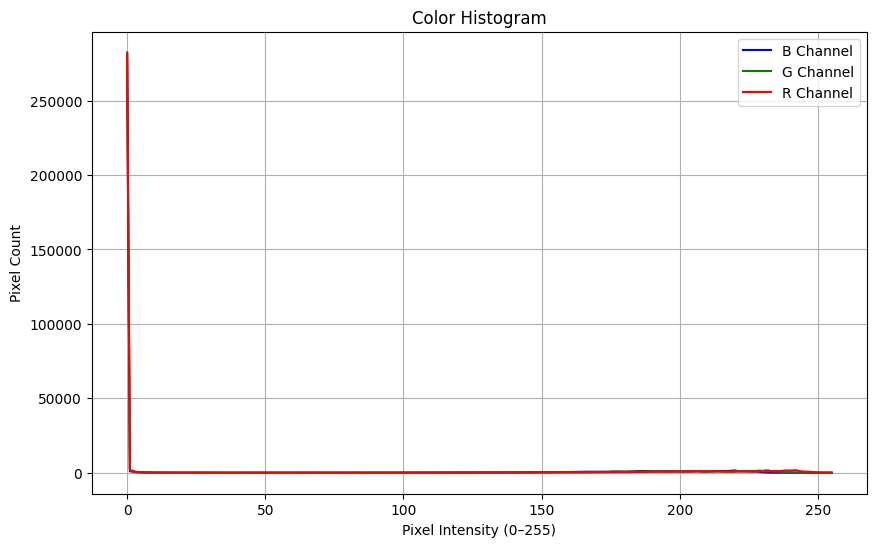

In [11]:
# buat color histogram untuk salah satu gambar
colors = ('b', 'g', 'r')

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23/kirmizi 552.jpg')
# print(image)
plt.figure(figsize=(10, 6))
plt.title('Color Histogram')
plt.xlabel('Pixel Intensity (0–255)')
plt.ylabel('Pixel Count')

for i, color in enumerate(colors):
    # 'image' -> warna asli dari gambar
    # '[256]' -> jumlah bin di histogram
    # '[0, 256]' -> range pixel valueny
    histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(histogram, color=color, label=f'{color.upper()} Channel')

plt.grid(True)
plt.legend()
plt.show()

Pixel intensity untuk semua color channel mencapai peak di pixel intensity = 0. Artinya gambar didominasi oleh warna hitam (pixel intensity=0). Selain itu, karena bentuk histogram untuk tiap channel hampir sama, artinya warna di dalam gambar yang bukan hitam bersifat lebih netral dan tidak condong ke merah, biru, atau hijau.

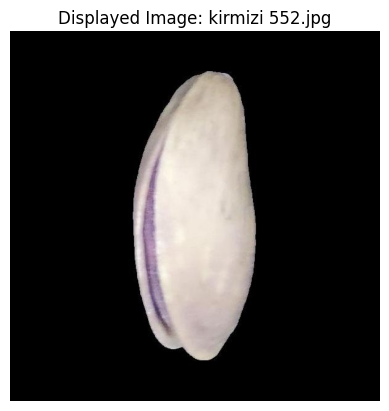

In [12]:
# tunjukkan salah satu gambar
image_contoh = Image.open('/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23/kirmizi 552.jpg')

plt.imshow(image_contoh)
plt.title("Displayed Image: kirmizi 552.jpg")
plt.axis('off')
plt.show()

# Read data untuk model

In [13]:
root_path = '/content/drive/MyDrive/Colab Notebooks/UAS DL/B_23'
root_path = pathlib.Path(root_path)

Load images ke variabel data dan otomatis resize jadi 100x100

In [14]:
batch_size = 32

data = keras.utils.image_dataset_from_directory(
    directory=root_path,
    label_mode=None,
    batch_size=batch_size,
    image_size=(100,100))

Found 1074 files.


In [15]:
data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None)>

tunjukkan beberapa gambar yang sudah di-load

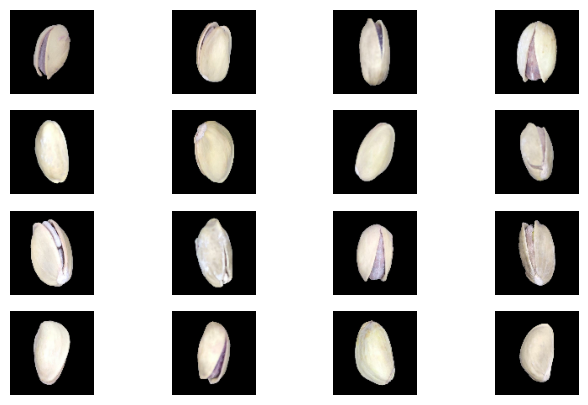

In [16]:
plt.figure(figsize=(8,5))
for images in data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

Normalisasi warna gambar supaya dari range awal 0-255 rangenya jadi -1 sampai 1

In [17]:
data = data.map(lambda d : ((d-127.5)/127.5))
data

<_MapDataset element_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None)>

# Buat model

Generator

In [18]:
latent_dim = 100

Jadinya perlu pakai 4 convolution layer untuk memenuhi persyaratan jumlah filter di soal dan output size. Layer convolution terakhir digunakan untuk ubah jumlah channelnya dari 16 jadi 3 saja supaya output shapenya jadi (100,100,3) bukan (100,100,16)

In [19]:
def Generator():
  generator = Sequential()
  generator.add(Dense(units=92*92*256, input_shape =[latent_dim], use_bias=False))
  generator.add(Reshape((92,92,256)))
  generator.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(1,1), padding ="valid", activation ="relu"))
  generator.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(1,1), padding ="valid", activation ="relu"))
  generator.add(Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=(1,1), padding ="valid", activation ="relu"))
  generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(1,1), padding ="valid", activation ="tanh"))

  return generator


G_model = Generator()
G_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2166784)        │   216,678,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 92, 92, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 94, 94, 64)     │       147,520 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 96, 96, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 98, 98, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 3)    │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,849,443 (827.21 MB)

 Trainable params: 216,849,443 (827.21 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
G_optm = Adam(learning_rate=0.00005, beta_1=0.5)

Discriminator

Gambar yang sudah dianalisa di-flatten dan dimasukkan ke dense layer yang jumlah unitnya 1 supaya discriminator bisa menentukan apakah gambar tersebut asli (dari dataset awal) atau palsu (dibuat oleh generator)

In [21]:
def Discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(filters=16, kernel_size=3, strides=(1,1), padding="valid", activation="relu", input_shape=(100,100,3)))
  discriminator.add(Conv2D(filters=32, kernel_size=3, strides=(1,1), padding="valid", activation="relu"))
  discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(1,1), padding="valid", activation="relu"))
  discriminator.add(Flatten())
  discriminator.add(Dense(units=1, activation="sigmoid"))

  return discriminator

D_model = Discriminator()
D_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
D_optm = Adam(learning_rate=0.00005, beta_1=0.5)

Buat random noise pake gaussian distribution. Jumlah random noise yg dihasilkan tidak perlu sama persis dengan input ke generator krn nnt akan diexpand di generator oleh dense layer

In [23]:
random_noise = tf.random.normal([1,latent_dim])

In [24]:
G_output_on_random_noise = G_model(random_noise, training=False)

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

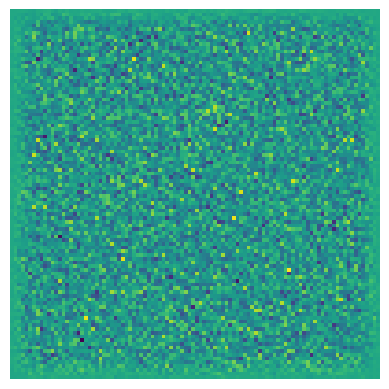

In [25]:
plt.imshow(G_output_on_random_noise[0, :, :, 0])
plt.axis("off")

In [26]:
D_output_on_random_noise = D_model(G_output_on_random_noise)
print(D_output_on_random_noise)

tf.Tensor([[0.49936208]], shape=(1, 1), dtype=float32)


Bangun GAN modelnya

Codenya dari keras sample

In [27]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # sample titik-titik random
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode jadi fake image (pakai generator)
        generated_images = self.generator(seed)
        # gabung dengan image asli
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # buat label - yang mana real dan fake
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # tambah random noise
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train  discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # sample titik-titik random
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # taruh label palsu yang mengatakan kalau semuanya real image
        misleading_labels = tf.zeros((batch_size, 1))

        # Train generator tapi jangan update weight dari discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [28]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

Buat gan modelnya

In [29]:
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

In [30]:
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

training model gan

In [32]:
epochs = 200
history = model.fit(data, epochs=epochs)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - d_loss: 0.5970 - g_loss: 0.9486
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - d_loss: 0.5948 - g_loss: 0.9486
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - d_loss: 0.5984 - g_loss: 0.9364
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - d_loss: 0.5964 - g_loss: 0.9433
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - d_loss: 0.5898 - g_loss: 0.9593
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - d_loss: 0.5953 - g_loss: 0.9600
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - d_loss: 0.5955 - g_loss: 0.9479
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - d_loss: 0.6307 - g_loss: 0.9473
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - d_loss: 0.5954 - g_loss: 0.9365
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - d_loss: 0.5890 - g_loss: 0.9740
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - d_loss: 0.6049 - g_loss: 0.9789
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━━━

Coba generate image baru

In [33]:
# buat random noise untuk dipakai buat images
noise = tf.random.normal([32, 100])
generated_images = G_model(noise, training=False)

In [34]:
# konversi nilai pixelnya kembali ke range 0-255
generated_images1 = (generated_images+127.5)*127.5

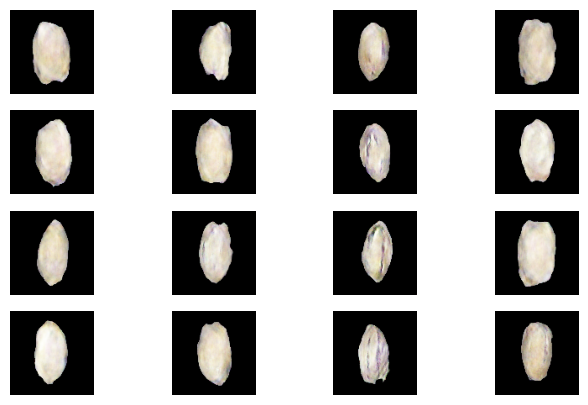

In [35]:
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()

Plot lossnya

In [36]:
d_loss = history.history['d_loss']
g_loss = history.history['g_loss']

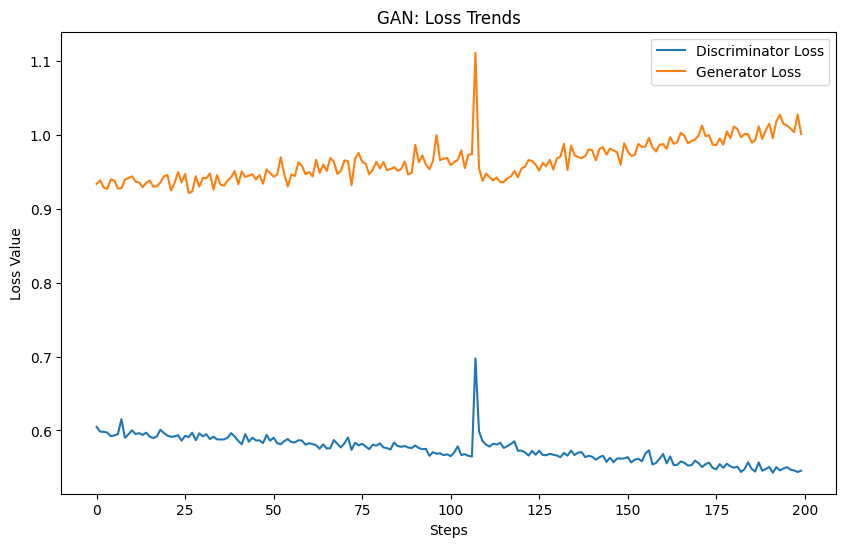

In [37]:
steps = [i for i in range(len(d_loss))]
plt.figure(figsize=(10, 6))
plt.plot(d_loss[:5000])
plt.plot(g_loss[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

# Modifikasi

## Modified model 1

Generator

In [38]:
latent_dim = 100

Perbedaannya adalah menggunakan stride 2 pada beberapa layer convolution dan melakukan batch normalization untuk mempercepat learning dari model

In [39]:
def Generator():
  generator = Sequential()
  generator.add(Dense(units=25*25*256, input_shape =[latent_dim], use_bias=False))
  generator.add(Reshape((25,25,256)))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(1,1), padding ="same", activation ="relu"))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(1,1), padding ="same", activation ="relu"))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(1,1), padding ="same", activation ="relu"))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2,2), padding ="same", activation ="relu"))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=(2,2), padding ="same", activation ="relu"))
  generator.add(BatchNormalization())
  generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(1,1), padding ="same", activation ="tanh"))

  return generator


G_model2 = Generator()
G_model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 160000)         │    16,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 25, 25, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 25, 25, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 50, 50, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 100, 100, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 100, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 100, 100, 3)    │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,985,443 (64.79 MB)

 Trainable params: 16,983,939 (64.79 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [40]:
G_optm2 = Adam(learning_rate=0.00005, beta_1=0.5)

Discriminator

Perbedaannya pakai stride 2 dan padding same untuk memastikan kalau output dari tiap layer memiliki bentuk yang diinginkan, tidak ada pemotongan yang tidak diinginkan, lalu menggunakan batch nomalization dan dropout untuk mempercepat learning rate

In [41]:
def Discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(filters=16, kernel_size=3, strides=(2,2), padding="same", activation="relu", input_shape=(100,100,3)))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))
  discriminator.add(Conv2D(filters=32, kernel_size=3, strides=(2,2), padding="same", activation="relu"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))
  discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same", activation="relu"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))
  discriminator.add(Conv2D(filters=128, kernel_size=3, strides=(2,2), padding="same", activation="relu"))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))
  discriminator.add(Flatten())
  discriminator.add(Dense(units=1, activation="sigmoid"))

  return discriminator

D_model2 = Discriminator()
D_model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,673 (408.88 KB)

 Trainable params: 104,193 (407.00 KB)

 Non-trainable params: 480 (1.88 KB)

In [42]:
D_optm2 = Adam(learning_rate=0.00005, beta_1=0.5)

Buat random noise pake gaussian distribution. Jumlah random noise yang dihasilkan tidak perlu sama persis dengan input ke generator karena nanti akan di-expand di generator oleh dense layer

In [43]:
random_noise2 = tf.random.normal([1,latent_dim])

In [44]:
G_output_on_random_noise2 = G_model2(random_noise2, training=False)

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

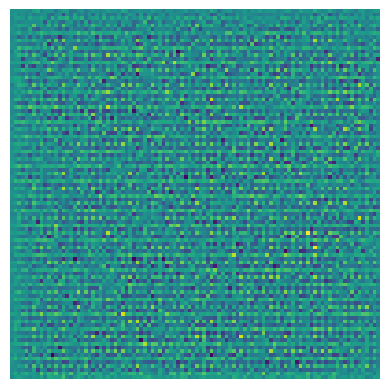

In [45]:
plt.imshow(G_output_on_random_noise2[0, :, :, 0])
plt.axis("off")

In [46]:
D_output_on_random_noise2 = D_model2(G_output_on_random_noise2)
print(D_output_on_random_noise2)

tf.Tensor([[0.49998498]], shape=(1, 1), dtype=float32)


Bangun GAN modelnya

Codenya dari keras sample

In [47]:
loss_fn2 = tf.keras.losses.BinaryCrossentropy()

Buat gan modelnya

In [48]:
model2 = GAN(discriminator=D_model2, generator=G_model2, latent_dim=latent_dim)

In [49]:
model2.compile(d_optimizer=D_optm2, g_optimizer=G_optm2, loss_fn=loss_fn2)

training model gan

In [50]:
epochs = 200
history2 = model2.fit(data, epochs=epochs)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 389ms/step - d_loss: 0.6553 - g_loss: 0.6978
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - d_loss: 0.4863 - g_loss: 0.7154
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - d_loss: 0.3538 - g_loss: 0.9265
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - d_loss: 0.2203 - g_loss: 1.3323
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - d_loss: 0.1093 - g_loss: 2.0878
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - d_loss: 0.0410 - g_loss: 3.3118
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - d_loss: 0.0044 - g_loss: 4.7814
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - d_loss: 0.0409 - g_loss: 4.2755
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - d_loss: 0.0111 - g_loss: 6.2913
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - d_loss: -0.0060 - g_loss: 7.4914
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - d_loss: -0.0061 - g_loss: 7.6461
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 

Coba generate image baru

In [51]:
# creating a random nosie to feed it to the trained Generator model
noise = tf.random.normal([32, 100])
# Generatine new images using the trained Generator model
generated_images2 = G_model2(noise, training=False)

In [52]:
generated_images21 = (generated_images2+127.5)*127.5

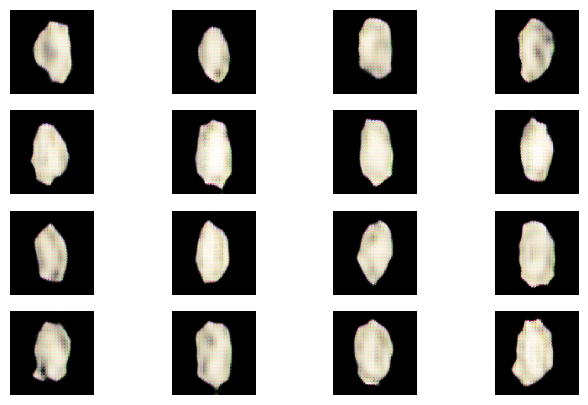

In [53]:
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_images21[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()

Plot lossnya

In [54]:
d_loss2 = history2.history['d_loss']
g_loss2 = history2.history['g_loss']

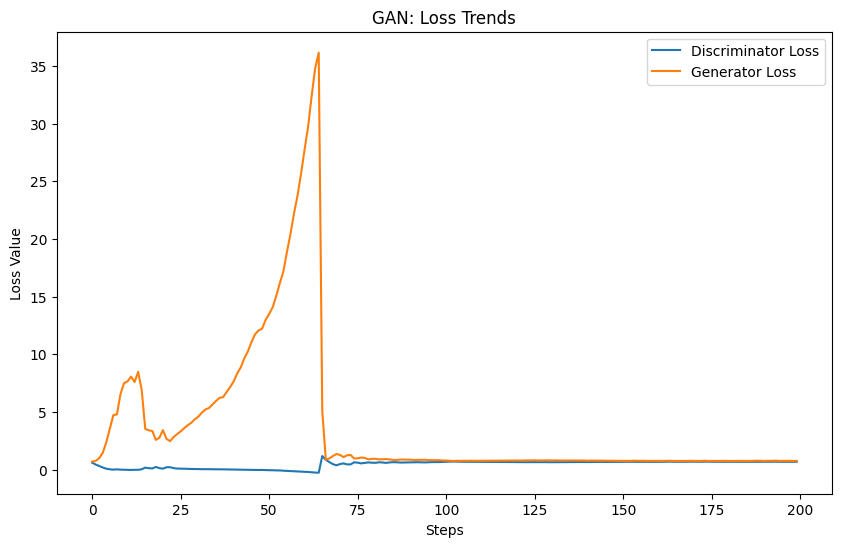

In [55]:
steps = [i for i in range(len(d_loss2))]
plt.figure(figsize=(10, 6))
plt.plot(d_loss2[:5000])
plt.plot(g_loss2[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

# Evaluasi

## Base model

In [56]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

In [57]:
# Load InceptionV3
inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

def calculate_inception_features_from_tensor(images_tensor, model, target_size=(299, 299), batch_size=32):
    #lakukan image extraction menggunakan InceptionnV3
    images_tensor = tf.cast(images_tensor, tf.float32)

    # Resize gambar jadi 299x299
    resized_images = tf.image.resize(images_tensor, target_size, method=tf.image.ResizeMethod.BILINEAR)

    # Preprocess input - normalisasi jadi range -1 sampai 1
    preprocessed_images = preprocess_input(resized_images)

    # Prediksi features
    features = model.predict(preprocessed_images, batch_size=batch_size, verbose=0)
    return features


def calculate_fid(real_features, generated_features):
    if len(real_features) < 2 or len(generated_features) < 2:
        print("Warning: Not enough samples (need at least 2) in one or both feature sets for reliable FID. Returning infinity.")
        return float('inf') # Return infinity if not enough samples for covariance

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2.0)

    # hitung akar dari product antara cov
    # pakai 'is_hermitian=True'untuk meningkatkan stabilitas nuerik
    covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0] # disp=False supaya tidak print

    # check dan perbaiki imaginary numbers dari sqrt
    if np.iscomplexobj(covmean):
        print("Warning: Complex numbers in covariance square root. Taking real part.")
        covmean = covmean.real

    # hitung skor fid
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [60]:
NUM_FID_SAMPLES = 32

# proses image yang dibuat oleh model
# pastikan jumlah sampel cukup
if generated_images1.shape[0] < NUM_FID_SAMPLES:
    print(f"Warning: Not enough generated images in the tensor ({generated_images1.shape[0]} < {NUM_FID_SAMPLES}). Using available samples.")
    generated_images_for_fid = generated_images1
else:
    generated_images_for_fid = generated_images1[:NUM_FID_SAMPLES]

generated_features = calculate_inception_features_from_tensor(
    generated_images_for_fid, inception_model
)
print(f"Generated features shape: {generated_features.shape}")

# proses data real image
real_images_list = []
# iterasi dan kumpulkan image sebanyak NUM_FID_SAMPLES yang ditentukan
for i, batch in enumerate(data):
    # untuk ambil imagenya saja
    if isinstance(batch, tuple):
        images_from_batch = batch[0]
    else:
        images_from_batch = batch

    real_images_list.append(images_from_batch)

    # kalau jumlah sample yang diambil sudah cukup, break
    if (i + 1) * images_from_batch.shape[0] >= NUM_FID_SAMPLES:
        break

# gabung real images yang sudah dikumpul
collected_real_images_tensor = tf.concat(real_images_list, axis=0)
if collected_real_images_tensor.shape[0] < NUM_FID_SAMPLES:
    print(f"Warning: Not enough real images collected from dataset ({collected_real_images_tensor.shape[0]} < {NUM_FID_SAMPLES}). Using available samples.")
    real_images_for_fid = collected_real_images_tensor
else:
    real_images_for_fid = collected_real_images_tensor[:NUM_FID_SAMPLES]


real_features = calculate_inception_features_from_tensor(
    real_images_for_fid, inception_model
)
print(f"Real features shape: {real_features.shape}")


# hitung skor FID
fid_score = calculate_fid(real_features, generated_features)

print(f" FID Score for base model: {fid_score:.2f}")

Generated features shape: (32, 2048)
Real features shape: (32, 2048)


/tmp/ipython-input-2361665434.py:31: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0] # disp=False supaya tidak print
/tmp/ipython-input-2361665434.py:31: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0] # disp=False supaya tidak print


 FID Score for base model: 226222.65


## Modified model

In [61]:
NUM_FID_SAMPLES = 32

# proses image yang dibuat oleh model
# pastikan juumlah sampel cukup
if generated_images21.shape[0] < NUM_FID_SAMPLES:
    print(f"Warning: Not enough generated images in the tensor ({generated_images21.shape[0]} < {NUM_FID_SAMPLES}). Using available samples.")
    generated_images_for_fid = generated_images21
else:
    generated_images_for_fid = generated_images21[:NUM_FID_SAMPLES]

generated_features = calculate_inception_features_from_tensor(
    generated_images_for_fid, inception_model
)
print(f"Generated features shape: {generated_features.shape}")

# proses data real image
real_images_list = []
# iterasi dan kumpulkan image sebanyak NUM_FID_SAMPLES yang ditentukan
for i, batch in enumerate(data):
    # untuk ambil imagenya saja
    if isinstance(batch, tuple):
        images_from_batch = batch[0]
    else:
        images_from_batch = batch

    real_images_list.append(images_from_batch)

    # kalau jumlah sample yang diambil sudah cukup, break
    if (i + 1) * images_from_batch.shape[0] >= NUM_FID_SAMPLES:
        break

# gabung real images yang sudah dikumpul
collected_real_images_tensor = tf.concat(real_images_list, axis=0)
if collected_real_images_tensor.shape[0] < NUM_FID_SAMPLES:
    print(f"Warning: Not enough real images collected from dataset ({collected_real_images_tensor.shape[0]} < {NUM_FID_SAMPLES}). Using available samples.")
    real_images_for_fid = collected_real_images_tensor
else:
    real_images_for_fid = collected_real_images_tensor[:NUM_FID_SAMPLES]


real_features = calculate_inception_features_from_tensor(
    real_images_for_fid, inception_model
)
print(f"Real features shape: {real_features.shape}")


# hitung skor FID
fid_score = calculate_fid(real_features, generated_features)

print(f"Final FID Score for modified model: {fid_score:.2f}")

Generated features shape: (32, 2048)
Real features shape: (32, 2048)


/tmp/ipython-input-2361665434.py:31: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0] # disp=False supaya tidak print
/tmp/ipython-input-2361665434.py:31: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1.dot(sigma2), disp=False)[0] # disp=False supaya tidak print


Final FID Score for modified model: 226050.73


Base model memiliki FID score 226222.65, sedangkan modified model memiliki FID score yang sedikit lebih kecil, yaitu 226050.73.  

Artinya, modified model bekerja dengan lebih baik daripada base model. Jika dilihat dari gambar yang dihasilkan, secara umum, base model menghasilkan gambar dengan tekstur yang lebih mirip dengan gambar asli tapi warna dari kulit kirmizi tercampur dengan isi kulit kirmizi, sedangkan modified model menghasilkan gambar dengan warna yang lebih mirip dengan gambar asli, tapi menghasilkan tekstur aneh seperti kotak-kotak.